In [41]:
#import required libraries
from keras.layers import Input, Dense
from keras.models import Model, Sequential
from keras import regularizers
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, roc_auc_score, roc_curve
from sklearn.preprocessing import StandardScaler
from sklearn.manifold import TSNE
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from imblearn.under_sampling import RandomUnderSampler

%matplotlib inline
plt.style.use('ggplot')

import warnings
warnings.filterwarnings('ignore')

In [2]:
df = pd.read_csv('creditcard.csv')
df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,0.090794,-0.551600,-0.617801,-0.991390,-0.311169,1.468177,-0.470401,0.207971,0.025791,0.403993,0.251412,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,-0.166974,1.612727,1.065235,0.489095,-0.143772,0.635558,0.463917,-0.114805,-0.183361,-0.145783,-0.069083,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,0.207643,0.624501,0.066084,0.717293,-0.165946,2.345865,-2.890083,1.109969,-0.121359,-2.261857,0.524980,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,-0.054952,-0.226487,0.178228,0.507757,-0.287924,-0.631418,-1.059647,-0.684093,1.965775,-1.232622,-0.208038,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,0.753074,-0.822843,0.538196,1.345852,-1.119670,0.175121,-0.451449,-0.237033,-0.038195,0.803487,0.408542,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [6]:
#summary of the dataset columns
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 284807 entries, 0 to 284806
Data columns (total 31 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   Time    284807 non-null  float64
 1   V1      284807 non-null  float64
 2   V2      284807 non-null  float64
 3   V3      284807 non-null  float64
 4   V4      284807 non-null  float64
 5   V5      284807 non-null  float64
 6   V6      284807 non-null  float64
 7   V7      284807 non-null  float64
 8   V8      284807 non-null  float64
 9   V9      284807 non-null  float64
 10  V10     284807 non-null  float64
 11  V11     284807 non-null  float64
 12  V12     284807 non-null  float64
 13  V13     284807 non-null  float64
 14  V14     284807 non-null  float64
 15  V15     284807 non-null  float64
 16  V16     284807 non-null  float64
 17  V17     284807 non-null  float64
 18  V18     284807 non-null  float64
 19  V19     284807 non-null  float64
 20  V20     284807 non-null  float64
 21  V21     28

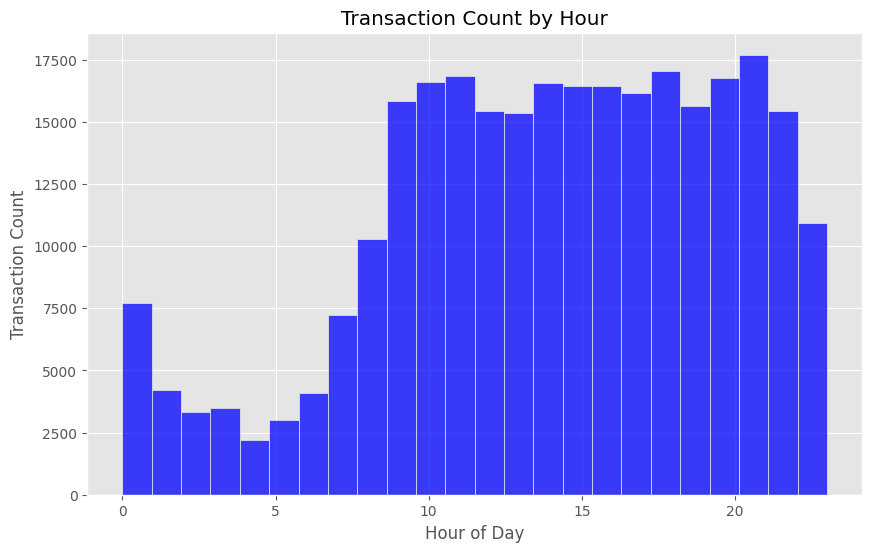

In [11]:
# Transaction time distribution
df['Hour'] = df['Time'] // 3600 % 24  # Convert seconds to hours
plt.figure(figsize=(10, 6))
sns.histplot(df['Hour'], bins=24, kde=False, color='blue')
plt.title("Transaction Count by Hour")
plt.xlabel("Hour of Day")
plt.ylabel("Transaction Count")
plt.show()

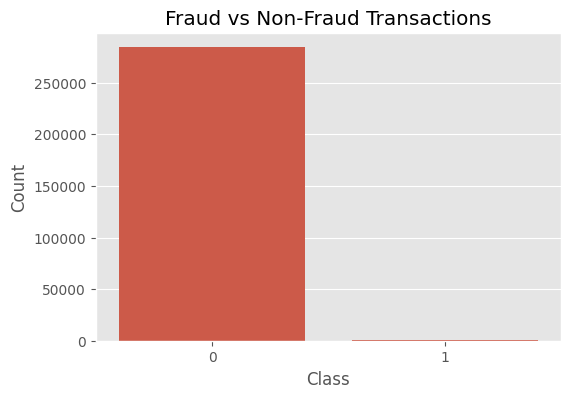

In [13]:
# Fraud vs Non-fraud transaction count
plt.figure(figsize=(6, 4))
sns.countplot(x='Class', data=df)
plt.title("Fraud vs Non-Fraud Transactions")
plt.xlabel("Class")
plt.ylabel("Count")
plt.show()

The classes are highly imbalanced.

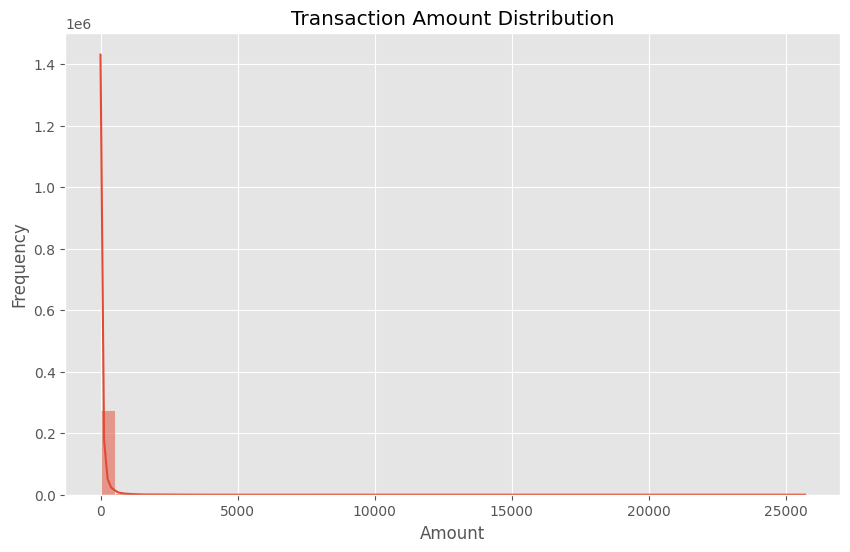

In [14]:
# Distribution of 'Amount' feature
plt.figure(figsize=(10, 6))
sns.histplot(df['Amount'], bins=50, kde=True)
plt.title("Transaction Amount Distribution")
plt.xlabel("Amount")
plt.ylabel("Frequency")
plt.show()

The feature is heavily right-skewed

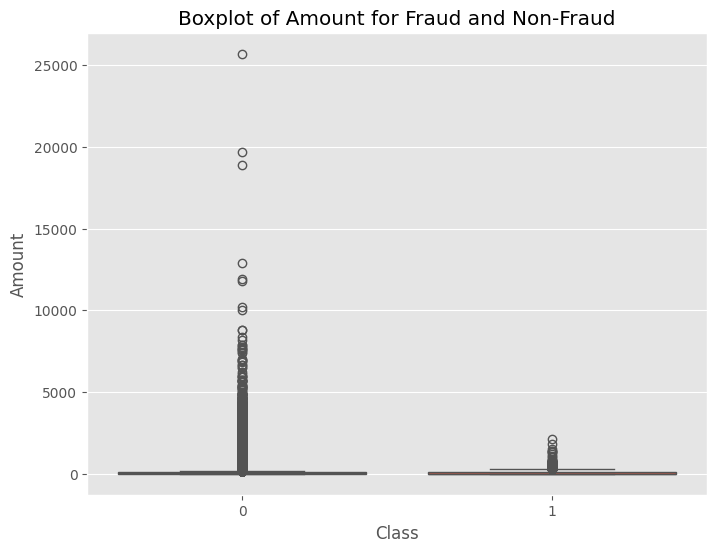

In [15]:
# Boxplot of Amount for Fraud vs Non-fraud
plt.figure(figsize=(8, 6))
sns.boxplot(x='Class', y='Amount', data=df)
plt.title("Boxplot of Amount for Fraud and Non-Fraud")
plt.xlabel("Class")
plt.ylabel("Amount")
plt.show()

In [16]:
# IQR Analysis
Q1 = df['Amount'].quantile(0.25)
Q3 = df['Amount'].quantile(0.75)
IQR = Q3 - Q1
print(f"IQR of Amount: {IQR}")

IQR of Amount: 71.565


In [19]:
df1 = df[df['Amount'] <= 8000]
print(df1['Class'].value_counts())
print('\nPercentage of Fraudulent Activity: {:.2%}'.format((df[df['Class']==1].shape[0]/df.shape[0])))

Class
0    284303
1       492
Name: count, dtype: int64

Percentage of Fraudulent Activity: 0.17%


Text(0.5, 1.0, 'Non-Fraudulent Transactions')

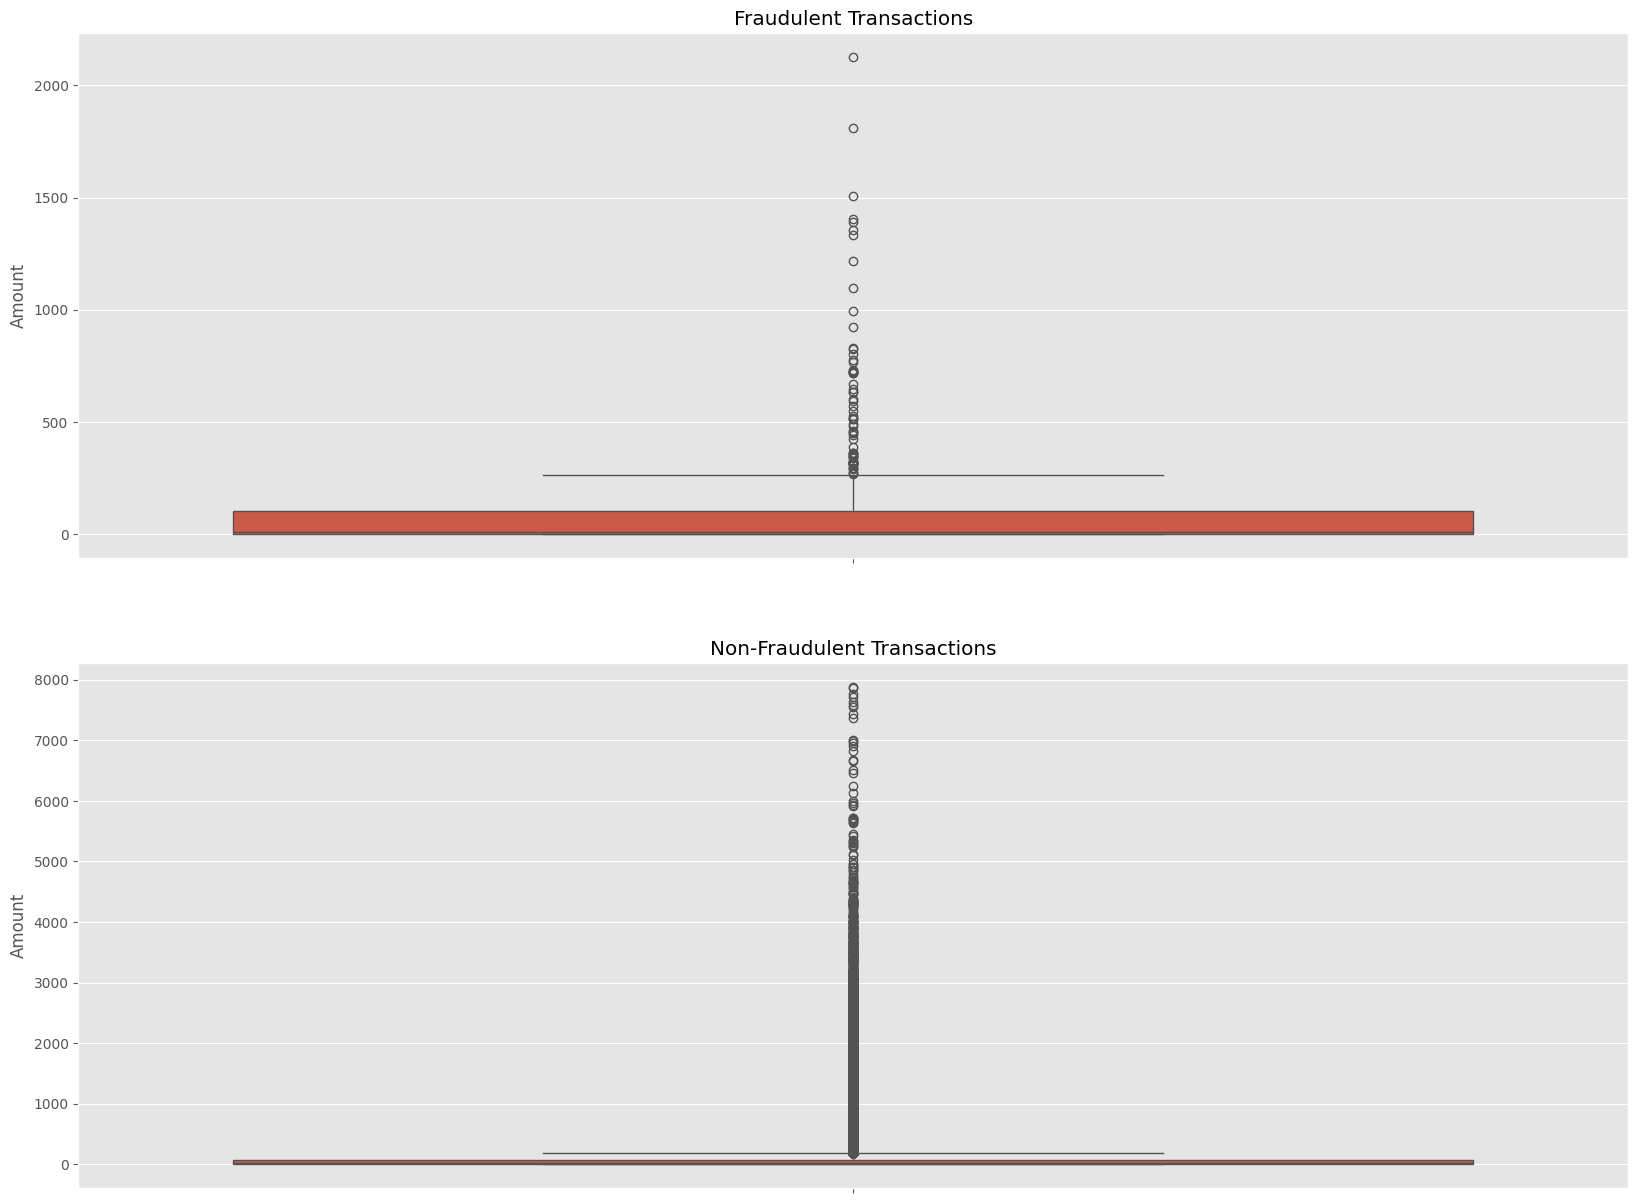

In [20]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(20, 15))

sns.boxplot(df1[df1['Class']==1].Amount, ax=ax1)
ax1.set_title('Fraudulent Transactions')

sns.boxplot(df1[df1['Class']==0].Amount, ax=ax2)
ax2.set_title('Non-Fraudulent Transactions')

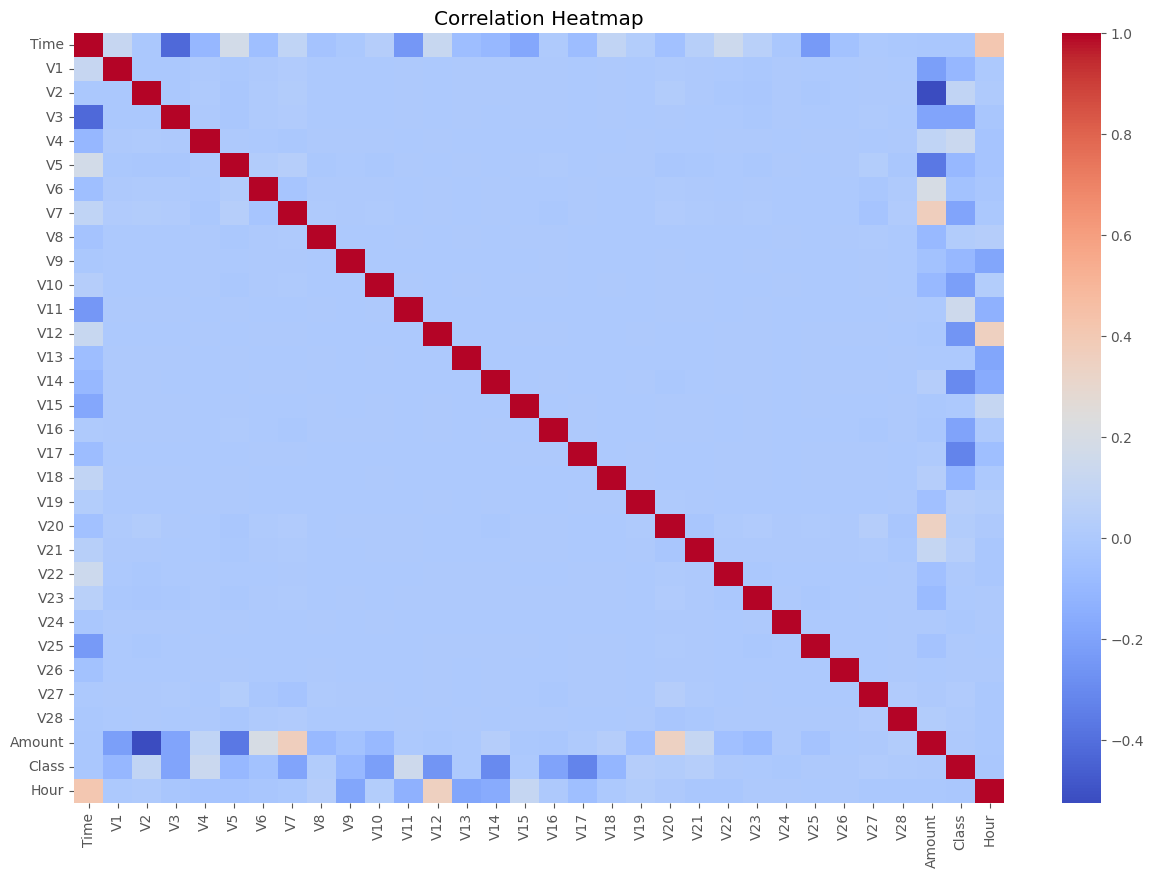

In [22]:
#correlation analysis among feature
correlation = df1.corr()
plt.figure(figsize=(15, 10))
sns.heatmap(correlation, cmap='coolwarm', annot=False)
plt.title("Correlation Heatmap")
plt.show()

The features are not showing any strong correlation relationship among themselves. So we do not have to remove any feature based on correlation analysis.

In [23]:
#Data Preprocessing and Undersampling
X = df1.drop(['Class', 'Time'], axis=1)
y = df1['Class']

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [25]:
# Undersampling
rus = RandomUnderSampler(random_state=24)
X_resampled, y_resampled = rus.fit_resample(X_scaled, y)

In [27]:
len(X_resampled)

984

In [28]:
len(y_resampled)

984

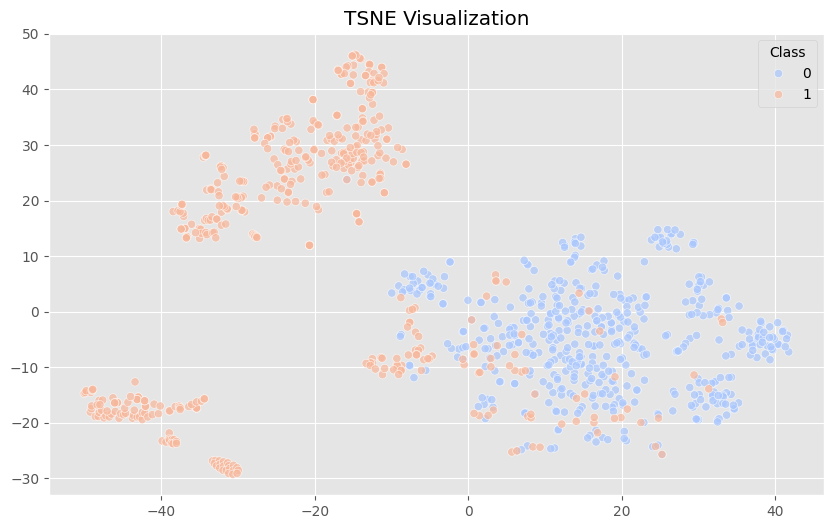

In [29]:
# Dimensionality reduction using TSNE
tsne = TSNE(n_components=2, random_state=24)
X_tsne = tsne.fit_transform(X_resampled)
plt.figure(figsize=(10, 6))
sns.scatterplot(x=X_tsne[:, 0], y=X_tsne[:, 1], hue=y_resampled, palette='coolwarm', alpha=0.7)
plt.title("TSNE Visualization")
plt.show()

In [33]:
#Constructing Autoencoder
input_dim = X_resampled.shape[1]  # Input dimension
encoding_dim_1 = 32  # First hidden layer dimension
encoding_dim_2 = 16  # Second hidden layer dimension

# Encoder
input_layer = Input(shape=(input_dim,))
encoder = Dense(encoding_dim_1, activation="relu")(input_layer)
encoder = Dense(encoding_dim_2, activation="relu")(encoder)

# Decoder
decoder = Dense(encoding_dim_1, activation="relu")(encoder)
decoder = Dense(input_dim, activation="sigmoid")(decoder)

# Autoencoder Model
autoencoder = Model(inputs=input_layer, outputs=decoder)
autoencoder.compile(optimizer='adam', loss='binary_crossentropy')  # Changed loss function to binary_crossentropy

In [34]:
# Training the Autoencoder
history = autoencoder.fit(X_resampled[y_resampled == 0],  # Train only on non-fraudulent data
                          X_resampled[y_resampled == 0],
                          epochs=50,  # Increased epochs
                          batch_size=256,
                          shuffle=True,
                          validation_split=0.2,
                          verbose=1)

Epoch 1/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 163ms/step - loss: 0.6807 - val_loss: 0.6754
Epoch 2/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 0.6711 - val_loss: 0.6669
Epoch 3/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 0.6604 - val_loss: 0.6582
Epoch 4/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 0.6494 - val_loss: 0.6492
Epoch 5/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 0.6392 - val_loss: 0.6399
Epoch 6/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step - loss: 0.6289 - val_loss: 0.6301
Epoch 7/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 0.6164 - val_loss: 0.6196
Epoch 8/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 0.6030 - val_loss: 0.6084
Epoch 9/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 0.5895 - val_loss: 0.5963
Epoch 10/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 0.5748 - val_loss: 0.5834
Epoch 11/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - loss: 0.5588 - val_loss: 0.5696
Epoch 12/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 0.5438 - val_loss: 0.5548


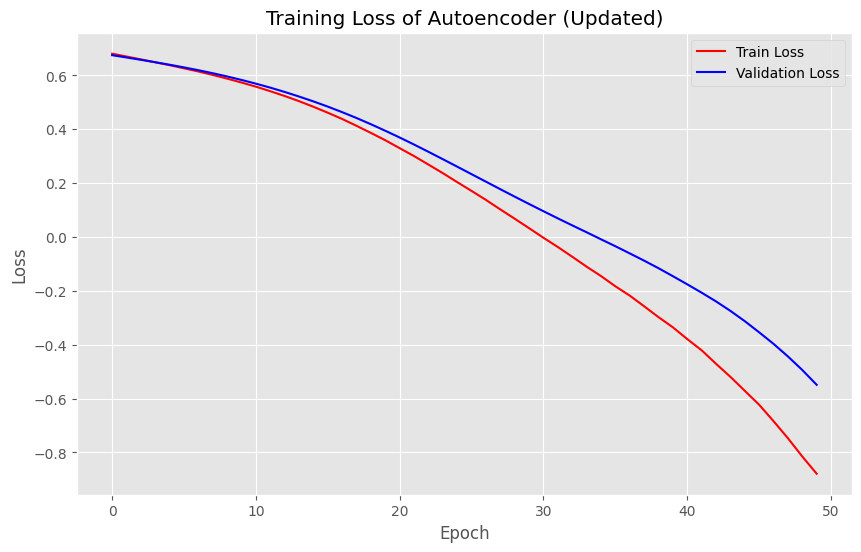

In [35]:
# Visualizing Training Loss
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Train Loss', color='red')
plt.plot(history.history['val_loss'], label='Validation Loss', color='blue')
plt.title('Training Loss of Autoencoder (Updated)')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [36]:
# Extracting Hidden Representations
encoder_model = Model(inputs=input_layer, outputs=encoder)
X_encoded = encoder_model.predict(X_resampled)

31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


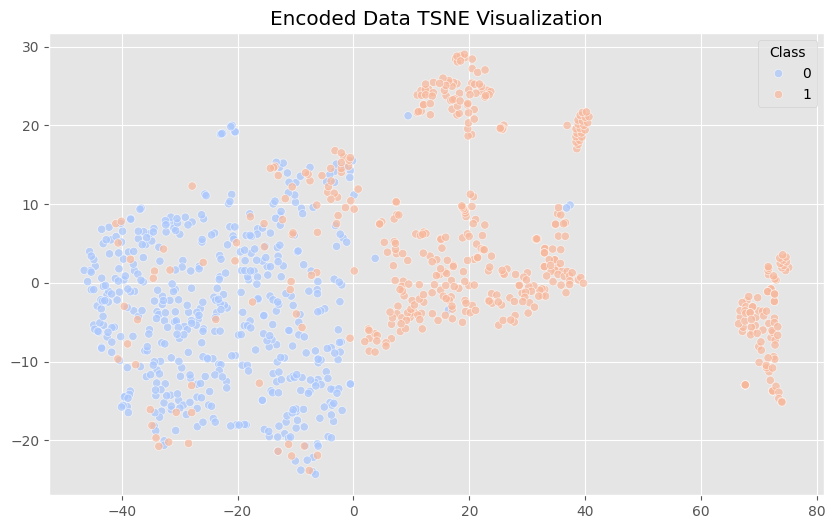

In [37]:
# TSNE on Encoded Data
X_tsne_encoded = tsne.fit_transform(X_encoded)
plt.figure(figsize=(10, 6))
sns.scatterplot(x=X_tsne_encoded[:, 0], y=X_tsne_encoded[:, 1], hue=y_resampled, palette='coolwarm', alpha=0.7)
plt.title("Encoded Data TSNE Visualization")
plt.show()

The autoencoder is learning useful hidden representations since we observe some level of separation between fraudulent and non-fraudulent transactions.

In [38]:
# Training Logistic Regression and Decision Tree Classifiers
X_train, X_test, y_train, y_test = train_test_split(X_encoded, y_resampled, test_size=0.3, random_state=24)

# Logistic Regression
logreg = LogisticRegression()
logreg.fit(X_train, y_train)
y_pred_logreg = logreg.predict(X_test)
print("Logistic Regression:")
print(classification_report(y_test, y_pred_logreg))
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred_logreg))

Logistic Regression:
              precision    recall  f1-score   support

           0       0.91      0.98      0.94       147
           1       0.98      0.91      0.94       149

    accuracy                           0.94       296
   macro avg       0.94      0.94      0.94       296
weighted avg       0.95      0.94      0.94       296

Confusion Matrix:
[[144   3]
 [ 14 135]]


In [39]:
# Decision Tree
dtree = DecisionTreeClassifier()
dtree.fit(X_train, y_train)
y_pred_tree = dtree.predict(X_test)
print("Decision Tree:")
print(classification_report(y_test, y_pred_tree))
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred_tree))

Decision Tree:
              precision    recall  f1-score   support

           0       0.89      0.85      0.87       147
           1       0.86      0.90      0.88       149

    accuracy                           0.88       296
   macro avg       0.88      0.87      0.87       296
weighted avg       0.88      0.88      0.87       296

Confusion Matrix:
[[125  22]
 [ 15 134]]


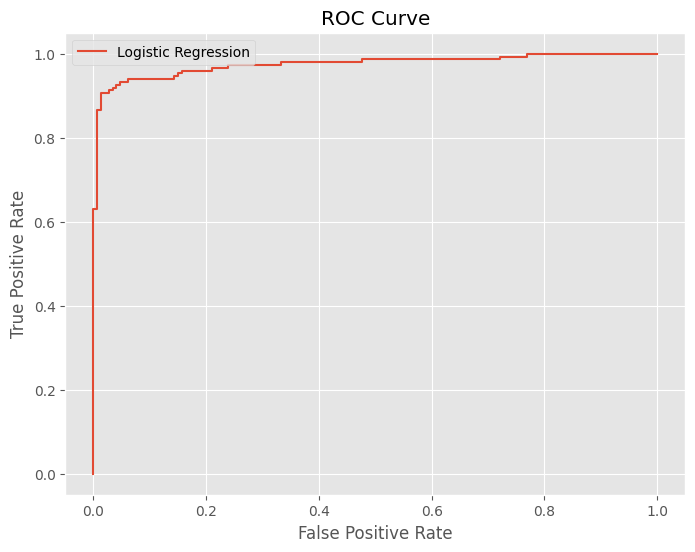

In [42]:
# Evaluation using ROC-AUC
fpr, tpr, _ = roc_curve(y_test, logreg.predict_proba(X_test)[:, 1])
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label='Logistic Regression')
plt.title("ROC Curve")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.show()

Logistic Regression performs better than Decision Tree in this case.

Autoencoder: The autoencoder learned a meaningful hidden representation of the data, which allowed downstream models (Logistic Regression and Decision Tree) to separate classes effectively. This is evident from:
t-SNE visualization showing good (but not perfect) clustering of classes.
Logistic Regression and Decision Tree achieving high recall and precision despite class imbalance.